# CanESM5 GMD paper Figure 19
## Sea ice annual cycle of extent and volume


### history
-  SJH, first look 2019-04-10


In [ ]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
%matplotlib inline
import cartopy.crs as ccrs
import cartopy
from pprint import pprint
import matplotlib.path as mpath
import sys
import os
import cmocean
import pandas as pd
from collections import defaultdict
import pickle
import modules.basic_stats as bst
import modules.plotting_module as pltm


In [2]:
#variables defs
%store -r start 
%store -r end
%store -r color_dict
%store -r siconc_limit
%store -r m2_per_km2
%store -r m3_per_km3
%store -r title_fontsize
%store -r label_fontsize
%store -r legend_fontsize

In [3]:
CanESM5 = {}
CanESM5_dir = 'input_data/CanESM5_cmip_dir/historical/'
areacello_CanESM5 = xr.open_dataset('input_data/CanESM5_cmip_dir/historical/r1i1p1f1/Ofx/areacello/gn/v20190429/areacello_Ofx_CanESM5_historical_r1i1p1f1_gn.nc')

process_CanESM5_realizations = False
if process_CanESM5_realizations:
    for root, subdirs, files in os.walk(CanESM5_dir):
        if 'SImon' in subdirs:
            subdirs[:] = ['SImon']
        if 'siconc' in subdirs:
            subdirs[:] = ['siconc']
        for filename in files:
            var, tab, model, expt, rl, grid, dates = filename.split('_')
            if rl.endswith('i1p1f1'):
                print(rl)
                siconc = xr.open_dataset(os.path.join(root,filename))
                try:
                    sithick = xr.open_dataset('/space/hall2/sitestore/eccc/crd/CMIP6/preliminary/CMIP6/CMIP/CCCma/CanESM5/historical/' + rl + '/SImon/sithick/gn/version/sithick_SImon_CanESM5_historical_' + rl + '_gn_185001-201412.nc')
                    merged  = xr.merge([areacello_CanESM5,siconc,sithick])
                except:
                    sithick = None
                    merged  = xr.merge([areacello_CanESM5,siconc])

                #select years
                merged_selyears = merged.sel(time=slice(start, end))

                #separate by hemisphere
                merged_nh = merged_selyears.where(merged_selyears.latitude > 0)
                merged_sh = merged_selyears.where(merged_selyears.latitude < 0)

                #select data by siconc limit (in %)
                merged_nh_si = merged_nh.where(merged_nh.siconc >= siconc_limit)
                merged_sh_si = merged_sh.where(merged_sh.siconc >= siconc_limit)

                #get siextent area integral 
                merged_nh_si_areamean = merged_nh_si.areacello.sum(dim=['j','i'])
                merged_sh_si_areamean = merged_sh_si.areacello.sum(dim=['j','i'])

                #get siextent monthly means
                siextent_nh = merged_nh_si_areamean.groupby('time.month').mean(dim='time')
                siextent_sh = merged_sh_si_areamean.groupby('time.month').mean(dim='time')    

                CanESM5[rl] = {'siextent_nh':siextent_nh,'siextent_sh':siextent_sh,'sivol_nh':None,'sivol_sh':None}

                if sithick is not None:
                    #calculate sivol (using all cells, not just >15% siconc as for extent)
                    merged_nh_sivol = merged_nh.sithick * merged_nh.areacello * merged_nh.siconc/100
                    merged_sh_sivol = merged_sh.sithick * merged_sh.areacello * merged_sh.siconc/100

                    #get sivol area integral 
                    merged_nh_sivol_areamean = merged_nh_sivol.sum(dim=['j','i'])
                    merged_sh_sivol_areamean = merged_sh_sivol.sum(dim=['j','i'])

                    #get sivol monthly means
                    sivol_nh = merged_nh_sivol_areamean.groupby('time.month').mean(dim='time')
                    sivol_sh = merged_sh_sivol_areamean.groupby('time.month').mean(dim='time')

                    CanESM5[rl]['sivol_nh'] = sivol_nh
                    CanESM5[rl]['sivol_sh'] = sivol_sh

    with open('input_data/processed_data/CanESM5_seaice_extent_vol.pickle', 'wb') as f:
        pickle.dump(CanESM5, f)  
        
else:
    with open('input_data/processed_data/CanESM5_seaice_extent_vol.pickle', 'rb') as f:
        CanESM5 = pickle.load(f)

In [4]:
CanESM2 = {}
CanESM2_dir = 'input_data/CanESM2_combined_ensemble/sic/'
areacella_CanESM2 = xr.open_dataset('input_data/CanESM2_large_ensemble/historical-r1/fx/atmos/areacella/r0i0p0/areacella_fx_CanESM2_historical-r1_r0i0p0.nc')

process_CanESM2_realizations = False
if process_CanESM2_realizations:
    for root, subdirs, files in os.walk(CanESM2_dir):
        for filename in files:
            if filename.startswith('sic_OImon_CanESM2_historical_d'): 
                var, tab, model, expt, rl, dates = filename.split('_')
                print(rl)
                siconc = xr.open_dataset(os.path.join(root,filename))

                try:
                    sithick = xr.open_dataset('input_data/CanESM2_combined_ensemble/sit/sit_OImon_CanESM2_historical_'+ rl +'_195001-202012.nc')
                    merged  = xr.merge([areacella_CanESM2,siconc,sithick])
                except:
                    sithick = None
                    merged  = xr.merge([areacella_CanESM2,siconc])

                #select years
                merged_selyears = merged.sel(time=slice(start, end))

                #separate by hemisphere
                merged_nh = merged_selyears.where(merged_selyears.lat > 0)
                merged_sh = merged_selyears.where(merged_selyears.lat < 0)

                #select data by siconc limit (in %)
                merged_nh_si = merged_nh.where(merged_nh.sic >= siconc_limit)
                merged_sh_si = merged_sh.where(merged_sh.sic >= siconc_limit)

                #get siextent area integral 
                merged_nh_si_areamean = merged_nh_si.areacella.sum(dim=['lat','lon'])
                merged_sh_si_areamean = merged_sh_si.areacella.sum(dim=['lat','lon'])

                #get siextent monthly means
                siextent_nh = merged_nh_si_areamean.groupby('time.month').mean(dim='time')
                siextent_sh = merged_sh_si_areamean.groupby('time.month').mean(dim='time')    

                CanESM2[rl] = {'siextent_nh':siextent_nh,'siextent_sh':siextent_sh,'sivol_nh':None,'sivol_sh':None}

                if sithick is not None:
                    #calculate sivol (using all cells, not just >15% siconc as for extent)
                    merged_nh_sivol = merged_nh.sit * merged_nh.areacella * merged_nh.sic/100
                    merged_sh_sivol = merged_sh.sit * merged_sh.areacella * merged_sh.sic/100

                    #get sivol area integral 
                    merged_nh_sivol_areamean = merged_nh_sivol.sum(dim=['lat','lon'])
                    merged_sh_sivol_areamean = merged_sh_sivol.sum(dim=['lat','lon'])

                    #get sivol monthly means
                    sivol_nh = merged_nh_sivol_areamean.groupby('time.month').mean(dim='time')
                    sivol_sh = merged_sh_sivol_areamean.groupby('time.month').mean(dim='time')

                    CanESM2[rl]['sivol_nh'] = sivol_nh
                    CanESM2[rl]['sivol_sh'] = sivol_sh

    with open('input_data/processed_data/CanESM2_seaice_extent_vol.pickle', 'wb') as f:
        pickle.dump(CanESM2, f)  
        
else:
    with open('input_data/processed_data/CanESM2_seaice_extent_vol.pickle', 'rb') as f:
        CanESM2 = pickle.load(f)

In [5]:
#get realization means 
CanESM5_nh_siextent_rels = xr.concat([CanESM5[rel]['siextent_nh'] for rel in CanESM5],dim='realization')
CanESM5_nh_siextent_relmean = CanESM5_nh_siextent_rels.mean('realization')
CanESM5_sh_siextent_rels = xr.concat([CanESM5[rel]['siextent_sh'] for rel in CanESM5],dim='realization')
CanESM5_sh_siextent_relmean = CanESM5_sh_siextent_rels.mean('realization')
CanESM5_nh_sivol_rels = xr.concat([CanESM5[rel]['sivol_nh'] for rel in CanESM5 if CanESM5[rel]['sivol_nh'] is not None],dim='realization')
CanESM5_nh_sivol_relmean = CanESM5_nh_sivol_rels.mean('realization')
CanESM5_sh_sivol_rels = xr.concat([CanESM5[rel]['sivol_sh'] for rel in CanESM5 if CanESM5[rel]['sivol_sh'] is not None],dim='realization')
CanESM5_sh_sivol_relmean = CanESM5_sh_sivol_rels.mean('realization')

CanESM2_nh_siextent_rels = xr.concat([CanESM2[rel]['siextent_nh'] for rel in CanESM2],dim='realization')
CanESM2_nh_siextent_relmean = CanESM2_nh_siextent_rels.mean('realization')
CanESM2_sh_siextent_rels = xr.concat([CanESM2[rel]['siextent_sh'] for rel in CanESM2],dim='realization')
CanESM2_sh_siextent_relmean = CanESM2_sh_siextent_rels.mean('realization')
CanESM2_nh_sivol_rels = xr.concat([CanESM2[rel]['sivol_nh'] for rel in CanESM2 if CanESM2[rel]['sivol_nh'] is not None],dim='realization')
CanESM2_nh_sivol_relmean = CanESM2_nh_sivol_rels.mean('realization')
CanESM2_sh_sivol_rels = xr.concat([CanESM2[rel]['sivol_sh'] for rel in CanESM2 if CanESM2[rel]['sivol_sh'] is not None],dim='realization')
CanESM2_sh_sivol_relmean = CanESM2_sh_sivol_rels.mean('realization')

In [6]:
#NSIDC (siextent)

#NSIDC
siconc_NSIDC_nh   = xr.open_dataset('input_data/processed_data/seaice_conc_monthly_nh_1981-2010_v03r01.nc')
siconc_NSIDC_sh   = xr.open_dataset('input_data/processed_data/seaice_conc_monthly_sh_1981-2010_v03r01.nc')

#get overall time slice (1981-2010 inclusive)
siconc_NSIDC_nh_selyears = siconc_NSIDC_nh.sel(time=slice(start, end))
siconc_NSIDC_sh_selyears = siconc_NSIDC_sh.sel(time=slice(start, end))

#select data by siconc limit (in %)
siconc_NSIDC_nh_si = siconc_NSIDC_nh_selyears.where(siconc_NSIDC_nh_selyears.goddard_merged_seaice_conc_monthly >= siconc_limit/100)
siconc_NSIDC_sh_si = siconc_NSIDC_sh_selyears.where(siconc_NSIDC_sh_selyears.goddard_merged_seaice_conc_monthly >= siconc_limit/100)

#get area integral 
grid_cell_area = 25*25 #data is on a 25x25km equal area grid
siconc_NSIDC_nh_areamean = siconc_NSIDC_nh_si.goddard_merged_seaice_conc_monthly.count(dim=['xgrid','ygrid'])*grid_cell_area
siconc_NSIDC_sh_areamean = siconc_NSIDC_sh_si.goddard_merged_seaice_conc_monthly.count(dim=['xgrid','ygrid'])*grid_cell_area

#get monthly means
siextent_NSIDC_nh = siconc_NSIDC_nh_areamean.groupby('time.month').mean(dim='time')
siextent_NSIDC_sh = siconc_NSIDC_sh_areamean.groupby('time.month').mean(dim='time')

In [7]:
#PIOMAS (sivol)

#PIOMAS arctic data are in ASCII table format with columns for each month and rows for years 1979 through present. Volume is given in 10^3 km3. Missing values are coded as -1 (or Nan).
#monthly data downloaded from http://psc.apl.uw.edu/research/projects/arctic-sea-ice-volume-anomaly/data/ on 20190416
si_PIOMAS_df = pd.read_csv('input_data/obs/PIOMAS.2sst.monthly.Current.v2.1.txt',delimiter = ' ', names = [1,2,3,4,5,6,7,8,9,10,11,12])

#select years of interest and get mean by month
si_PIOMAS_df_selyears = si_PIOMAS_df.drop([1979,1980,2011,2012,2013,2014,2015,2016,2017,2018,2019])
si_PIOMAS_df_selyears_means = si_PIOMAS_df_selyears.mean()

#convert to xarray for consistency in plotting
sivol_PIOMAS = si_PIOMAS_df_selyears_means.to_xarray()

In [8]:
#GIOMAS (sivol)

GIOMAS =  xr.open_mfdataset('input_data/obs/GIOMAS/heff.*.nc',  concat_dim='year')

GIOMAS_selyears = GIOMAS.sel(year=slice(start, end))
GIOMAS_selyears_vals = GIOMAS_selyears.where(GIOMAS_selyears.heff < 9999.) #remove fill values

#separate by hemisphere
GIOMAS_nh = GIOMAS_selyears_vals.where(GIOMAS_selyears_vals.lat_scaler > 0)
GIOMAS_sh = GIOMAS_selyears_vals.where(GIOMAS_selyears_vals.lat_scaler < 0)

#calculate sivol 
GIOMAS_nh_sivol = (GIOMAS_nh.heff/1000) * GIOMAS_nh.dxt * GIOMAS_nh.dyt #heff in m, dxt, dyt in km -> result in km3
GIOMAS_sh_sivol = (GIOMAS_sh.heff/1000) * GIOMAS_sh.dxt * GIOMAS_sh.dyt

#get sivol area integral 
GIOMAS_nh_sivol_areamean = GIOMAS_nh_sivol.sum(dim=['i', 'j'])
GIOMAS_sh_sivol_areamean = GIOMAS_sh_sivol.sum(dim=['i', 'j'])

#get monthly means
sivol_GIOMAS_nh = GIOMAS_nh_sivol_areamean.groupby('n').mean()
sivol_GIOMAS_sh = GIOMAS_sh_sivol_areamean.groupby('n').mean()

/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/xarray/core/groupby.py:639: FutureWarning: Default reduction dimension will be changed to the grouped dimension in a future version of xarray. To silence this warning, pass dim=xarray.ALL_DIMS explicitly.
  skipna=skipna, allow_lazy=True, **kwargs)


/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in greater
  return func(*args2)
/home/ords/crd/ccrn/scrd104/miniconda3/lib/python3.6/site-packages/dask/core.py:119: RuntimeWarning: invalid value encountered in less
  return func(*args2)


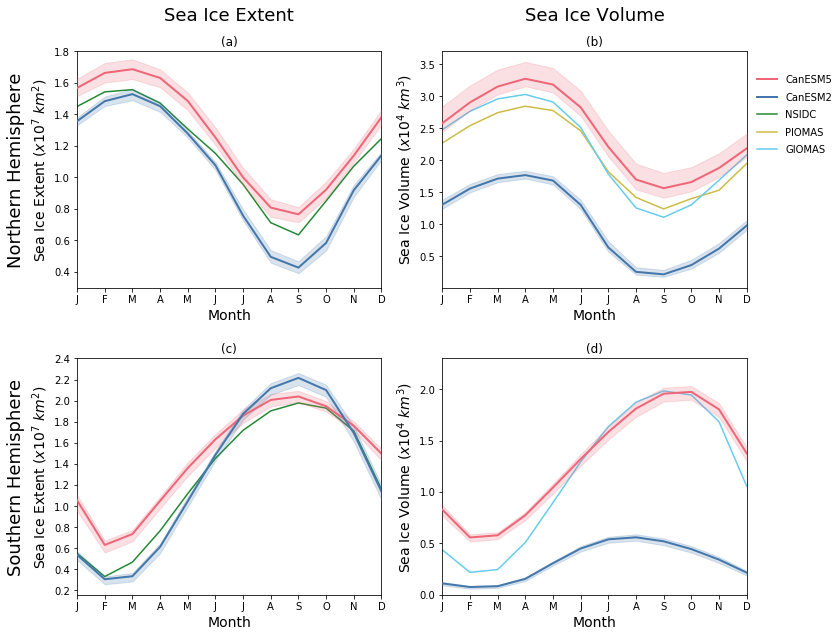

In [9]:
#plotting
fig = plt.figure(figsize=(12,10))

siextent_scale_factor = 1e7
sivolume_scale_factor = 1e4


ax1 = plt.subplot(2,2,1)
ax1.set_title('(a)')
ax1.text(0.5, 1.15, 'Sea Ice Extent', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=ax1.transAxes)
ax1.text(-0.2, 0.5, 'Northern Hemisphere', horizontalalignment='center', verticalalignment='center',rotation='vertical', fontsize=title_fontsize, transform=ax1.transAxes)
ax1.plot(CanESM5_nh_siextent_relmean.month, CanESM5_nh_siextent_relmean/siextent_scale_factor/m2_per_km2, label='CanESM5',color=color_dict['CanESM5'],linewidth='2', zorder=10)
ax1.fill_between(CanESM5_nh_siextent_rels.month, CanESM5_nh_siextent_rels.min(dim='realization')/siextent_scale_factor/m2_per_km2, CanESM5_nh_siextent_rels.max(dim='realization')/siextent_scale_factor/m2_per_km2, color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax1.plot(CanESM2_nh_siextent_relmean.month, CanESM2_nh_siextent_relmean/siextent_scale_factor/m2_per_km2, label='CanESM2',color=color_dict['CanESM2'],linewidth='2', zorder=10)
ax1.fill_between(CanESM2_nh_siextent_rels.month, CanESM2_nh_siextent_rels.min(dim='realization')/siextent_scale_factor/m2_per_km2, CanESM2_nh_siextent_rels.max(dim='realization')/siextent_scale_factor/m2_per_km2, color=color_dict['CanESM2'], alpha=0.2, zorder=10)
ax1.plot(siextent_NSIDC_nh.month, siextent_NSIDC_nh/siextent_scale_factor, label='NSIDC', color=color_dict['NSIDC'])
ax1.set_ylabel('Sea Ice Extent ($x10^7$ $km^2$)', fontsize=label_fontsize)
ax1.set_ylim(0.3,1.8)


ax2 = plt.subplot(2,2,2)
ax2.set_title('(b)')
ax2.text(0.5, 1.15, 'Sea Ice Volume', horizontalalignment='center', verticalalignment='center', fontsize=title_fontsize, transform=ax2.transAxes)
ax2.plot(CanESM5_nh_sivol_relmean.month, CanESM5_nh_sivol_relmean/siextent_scale_factor/m2_per_km2, label='CanESM5',color=color_dict['CanESM5'],linewidth='2', zorder=10)
ax2.fill_between(CanESM5_nh_sivol_rels.month, CanESM5_nh_sivol_rels.min(dim='realization')/siextent_scale_factor/m2_per_km2, CanESM5_nh_sivol_rels.max(dim='realization')/siextent_scale_factor/m2_per_km2, color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax2.plot(CanESM2_nh_sivol_relmean.month, CanESM2_nh_sivol_relmean/siextent_scale_factor/m2_per_km2, label='CanESM2',color=color_dict['CanESM2'],linewidth='2', zorder=10)
ax2.fill_between(CanESM2_nh_sivol_rels.month, CanESM2_nh_sivol_rels.min(dim='realization')/siextent_scale_factor/m2_per_km2, CanESM2_nh_sivol_rels.max(dim='realization')/siextent_scale_factor/m2_per_km2, color=color_dict['CanESM2'], alpha=0.2, zorder=10)
ax2.plot(sivol_PIOMAS.index, sivol_PIOMAS*1000/sivolume_scale_factor, label='PIOMAS', color=color_dict['PIOMAS'])
ax2.plot(sivol_GIOMAS_nh.n+1, sivol_GIOMAS_nh/sivolume_scale_factor, label='GIOMAS', color=color_dict['GIOMAS'])
ax2.set_ylabel('Sea Ice Volume ($x10^4$ $km^3$)', fontsize=label_fontsize)


ax3 = plt.subplot(2,2,3)
ax3.set_title('(c)')
ax3.text(-0.2, 0.5, 'Southern Hemisphere', horizontalalignment='center', verticalalignment='center',rotation='vertical', fontsize=title_fontsize, transform=ax3.transAxes)
ax3.plot(CanESM5_sh_siextent_relmean.month, CanESM5_sh_siextent_relmean/siextent_scale_factor/m2_per_km2, label='CanESM5',color=color_dict['CanESM5'],linewidth='2', zorder=10)
ax3.fill_between(CanESM5_sh_siextent_rels.month, CanESM5_sh_siextent_rels.min(dim='realization')/siextent_scale_factor/m2_per_km2, CanESM5_sh_siextent_rels.max(dim='realization')/siextent_scale_factor/m2_per_km2, color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax3.plot(CanESM2_sh_siextent_relmean.month, CanESM2_sh_siextent_relmean/siextent_scale_factor/m2_per_km2, label='CanESM2',color=color_dict['CanESM2'],linewidth='2', zorder=10)
ax3.fill_between(CanESM2_sh_siextent_rels.month, CanESM2_sh_siextent_rels.min(dim='realization')/siextent_scale_factor/m2_per_km2, CanESM2_sh_siextent_rels.max(dim='realization')/siextent_scale_factor/m2_per_km2, color=color_dict['CanESM2'], alpha=0.2, zorder=10)
ax3.plot(siextent_NSIDC_sh.month, siextent_NSIDC_sh/siextent_scale_factor, label='NSIDC', color=color_dict['NSIDC'])
ax3.set_ylabel('Sea Ice Extent ($x10^7$ $km^2$)', fontsize=label_fontsize)
ax3.yaxis.set_ticks(np.arange(0.2, 2.41, 0.2))



ax4 = plt.subplot(2,2,4)
ax4.set_title('(d)')
ax4.plot(CanESM5_sh_sivol_relmean.month, CanESM5_sh_sivol_relmean/siextent_scale_factor/m2_per_km2, label='CanESM5',color=color_dict['CanESM5'],linewidth='2', zorder=10)
ax4.fill_between(CanESM5_sh_sivol_rels.month, CanESM5_sh_sivol_rels.min(dim='realization')/siextent_scale_factor/m2_per_km2, CanESM5_sh_sivol_rels.max(dim='realization')/siextent_scale_factor/m2_per_km2, color=color_dict['CanESM5'], alpha=0.2, zorder=10)
ax4.plot(CanESM2_sh_sivol_relmean.month, CanESM2_sh_sivol_relmean/siextent_scale_factor/m2_per_km2, label='CanESM2',color=color_dict['CanESM2'],linewidth='2', zorder=10)
ax4.fill_between(CanESM2_sh_sivol_rels.month, CanESM2_sh_sivol_rels.min(dim='realization')/siextent_scale_factor/m2_per_km2, CanESM2_sh_sivol_rels.max(dim='realization')/siextent_scale_factor/m2_per_km2, color=color_dict['CanESM2'], alpha=0.2, zorder=10)
ax4.plot(sivol_GIOMAS_sh.n+1, sivol_GIOMAS_sh/sivolume_scale_factor, label='GIOMAS', color=color_dict['GIOMAS'])
ax4.set_ylabel('Sea Ice Volume ($x10^4$ $km^3$)', fontsize=label_fontsize)
ax4.set_ylim(0.0,2.3)

labels = []
handles = []
for ax in [ax1,ax2,ax3,ax4]:
    ax_handles, ax_labels = ax.get_legend_handles_labels()
    for h,l in zip(ax_handles,ax_labels):
        if l not in labels:
            labels.append(l)
            handles.append(h)
    ax.set_xlim(left=1, right=12)
    ax.set_xticks(np.arange(1,13,1))
    ax.set_xticklabels(['J','F','M','A','M','J','J','A','S','O','N','D'])
    ax.set_xlabel('Month', fontsize=label_fontsize)
    ax.yaxis.set_major_formatter(plticker.FormatStrFormatter('%.1f'))
    
plt.rcParams['xtick.labelsize']=label_fontsize
plt.rcParams['ytick.labelsize']=label_fontsize
plt.figlegend(handles, labels, loc=(0.9,0.75), ncol=1, labelspacing=0.75, frameon=False)
plt.subplots_adjust(wspace=0.2, hspace=0.3)  


plt.savefig('plots/fig-19_seaice_vol-extent.png', bbox_inches='tight')
plt.savefig('plots/fig-19_seaice_vol-extent.pdf', bbox_inches='tight')

In [ ]:
##### statistics - for annual cycle

CanESM5_stats_nh = CanESM5_nh_siextent_relmean/m2_per_km2
CanESM5_stats_sh = CanESM5_sh_siextent_relmean/m2_per_km2

CanESM2_stats_nh = CanESM2_nh_siextent_relmean/m2_per_km2
CanESM2_stats_sh = CanESM2_sh_siextent_relmean/m2_per_km2

NSIDC_stats_nh = siextent_NSIDC_nh
NSIDC_stats_sh = siextent_NSIDC_sh



xyzt = 'FFFT'
av_dims = ['time','lat','lon'] #dimensions over which to average (time for global time means, time and lon for zonal means and sections,time lat and lon for timeseries)
weight  = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
calc_skill_score = False


#the following lists will be zipped for the stats calcs, so all info should be entered accordingly
model_names    = ['CanESM5','CanESM5',
                  'CanESM2','CanESM2']
model_datasets    = [CanESM5_stats_nh,CanESM5_stats_sh,
                     CanESM2_stats_nh,CanESM2_stats_sh]
model_fulldatasets= [None,None,None,None]

obs_names     = ['NSIDC','NSIDC','NSIDC','NSIDC']
obs_datasets     = [NSIDC_stats_nh,NSIDC_stats_sh,
                    NSIDC_stats_nh,NSIDC_stats_sh,]
obs_fulldatasets = [None,None,None,None]

stats_names = ['si_extent_nh_anncycle_v_NSIDC','si_extent_sh_anncycle_v_NSIDC',
               'si_extent_nh_anncycle_v_NSIDC_CanESM2','si_extent_sh_anncycle_v_NSIDC_CanESM2',]
varslist = ['si_extent_nh_anncycle','si_extent_sh_anncycle',
            'si_extent_nh_anncycle','si_extent_sh_anncycle',]         


bst.calc_stats_and_write(obs_datasets, obs_fulldatasets, obs_names, model_datasets, model_fulldatasets, model_names, stats_names, varslist, weight, xyzt, av_dims, start, end, calc_skill_score=calc_skill_score)